Epoch 1/50, Loss: 1.3083
Epoch 2/50, Loss: 0.8196
Epoch 3/50, Loss: 0.5264
Epoch 4/50, Loss: 0.4069
Epoch 5/50, Loss: 0.3569
Epoch 6/50, Loss: 0.3041
Epoch 7/50, Loss: 0.2577
Epoch 8/50, Loss: 0.2356
Epoch 9/50, Loss: 0.2251
Epoch 10/50, Loss: 0.2036
Epoch 11/50, Loss: 0.2082
Epoch 12/50, Loss: 0.2029
Epoch 13/50, Loss: 0.1799
Epoch 14/50, Loss: 0.2085
Epoch 15/50, Loss: 0.2077
Epoch 16/50, Loss: 0.1729
Epoch 17/50, Loss: 0.1585
Epoch 18/50, Loss: 0.1744
Epoch 19/50, Loss: 0.1396
Epoch 20/50, Loss: 0.1630
Epoch 21/50, Loss: 0.1690
Epoch 22/50, Loss: 0.1736
Epoch 23/50, Loss: 0.1699
Epoch 24/50, Loss: 0.1235
Epoch 25/50, Loss: 0.1440
Epoch 26/50, Loss: 0.1328
Epoch 27/50, Loss: 0.1230
Epoch 28/50, Loss: 0.1361
Epoch 29/50, Loss: 0.1296
Epoch 30/50, Loss: 0.1261
Epoch 31/50, Loss: 0.1487
Epoch 32/50, Loss: 0.1296
Epoch 33/50, Loss: 0.1141
Epoch 34/50, Loss: 0.1511
Epoch 35/50, Loss: 0.1179
Epoch 36/50, Loss: 0.1483
Epoch 37/50, Loss: 0.1306
Epoch 38/50, Loss: 0.1074
Epoch 39/50, Loss: 0.

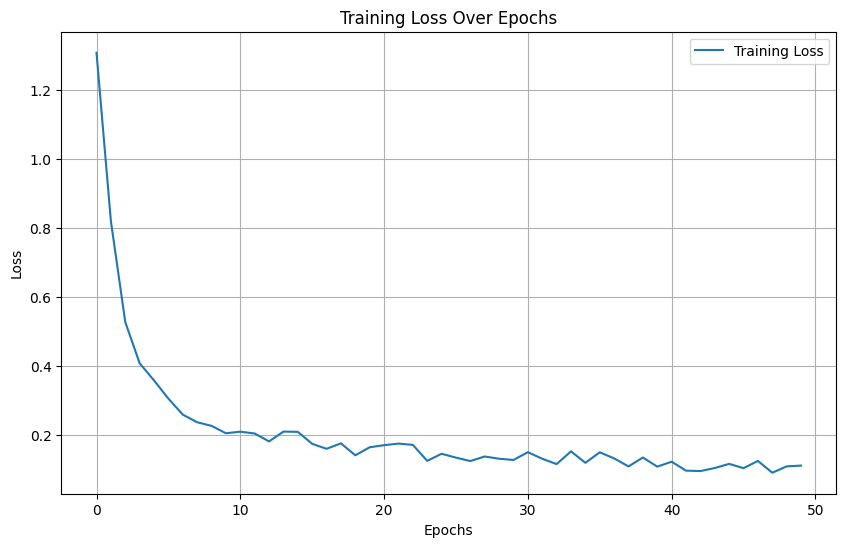

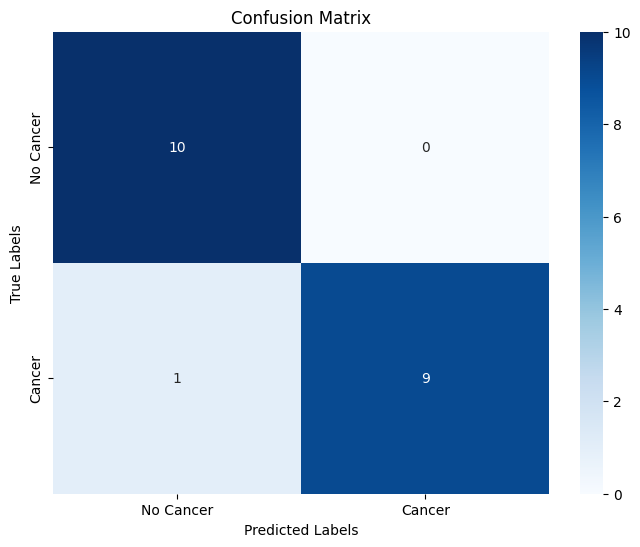

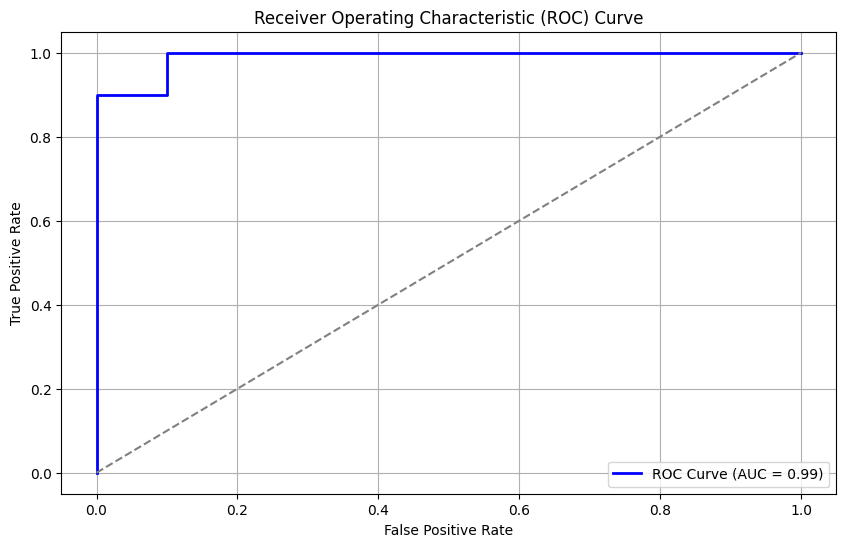

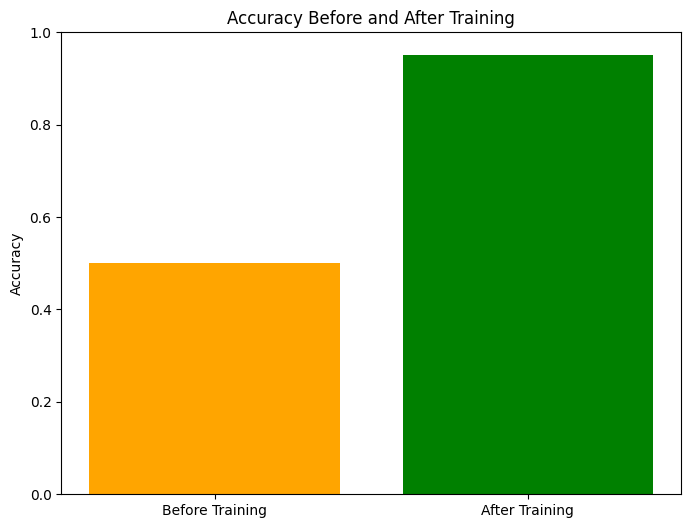

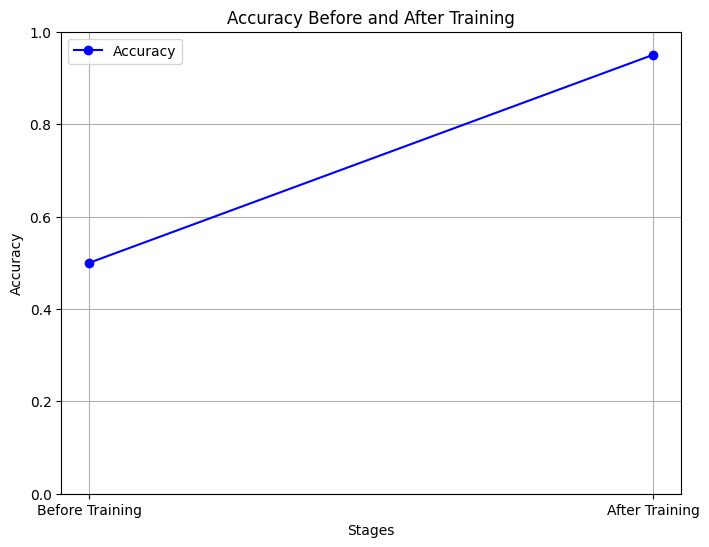

In [2]:
# Import Necessary Libraries
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Parameters
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Data Preprocessing
def preprocess_data(cancer_dir, no_cancer_dir, img_size=(224, 224)):
    from PIL import Image
    def load_images_from_folder(folder, label):
        images = []
        labels = []
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            with Image.open(filepath) as img:
                img = img.resize(img_size)
                img_array = np.array(img)
                if img_array.ndim == 2:  # Convert grayscale to RGB
                    img_array = np.stack([img_array] * 3, axis=-1)
                images.append(img_array)
                labels.append(label)
        return np.array(images), np.array(labels)

    cancer_images, cancer_labels = load_images_from_folder(cancer_dir, 1)
    no_cancer_images, no_cancer_labels = load_images_from_folder(no_cancer_dir, 0)

    X = np.concatenate((cancer_images, no_cancer_images), axis=0)
    y = np.concatenate((cancer_labels, no_cancer_labels), axis=0)

    return X / 255.0, y  # Normalize to [0, 1]

# Define Model Components
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, 512),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambd, None

def grad_reverse(x, lambd):
    return GradReverse.apply(x, lambd)

class DomainDiscriminator(nn.Module):
    def __init__(self):
        super(DomainDiscriminator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, lambd):
        x = grad_reverse(x, lambd)
        return self.fc(x)

class DANN_IRM_Model(nn.Module):
    def __init__(self, num_classes=2):
        super(DANN_IRM_Model, self).__init__()
        self.feature_extractor = FeatureExtractor()
        self.classifier = nn.Linear(512, num_classes)
        self.domain_discriminator = DomainDiscriminator()

    def forward(self, x, lambd):
        features = self.feature_extractor(x)
        class_preds = self.classifier(features)
        domain_preds = self.domain_discriminator(features, lambd)
        return class_preds, domain_preds

# Load and Prepare Data
cancer_dir = r"D:\\trainning data\\I\\II 1"
no_cancer_dir = r"D:\\trainning data\\I\\II 0"
X, y = preprocess_data(cancer_dir, no_cancer_dir)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, transform=train_transform)
test_dataset = CustomDataset(X_test, y_test, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize Model
model = DANN_IRM_Model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion_class = nn.CrossEntropyLoss()
criterion_domain = nn.BCELoss()

# Training Loop with Loss Tracking
epoch_losses = []

def train_model():
    model.train()

    for epoch in range(EPOCHS):
        epoch_loss = 0.0
        lambd = 2 / (1 + np.exp(-10 * epoch / EPOCHS)) - 1

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            class_preds, domain_preds = model(images, lambd)
            loss_class = criterion_class(class_preds, labels.long())  # Fixed data type here

            domain_labels = torch.cat(
                [torch.ones(class_preds.size(0) // 2), torch.zeros(class_preds.size(0) // 2)]
            ).to(DEVICE).unsqueeze(1)

            loss_domain = criterion_domain(domain_preds, domain_labels)
            loss = loss_class + 0.1 * loss_domain
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader):.4f}")

def evaluate_model():
    model.eval()
    all_preds, all_labels, all_scores = [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            class_preds, _ = model(images, lambd=0)
            _, preds = torch.max(class_preds, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(class_preds.softmax(dim=1)[:, 1].cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    return accuracy, all_labels, all_preds, all_scores

# Plotting Functions
def plot_training_loss():
    plt.figure(figsize=(10, 6))
    plt.plot(epoch_losses, label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def plot_accuracy_before_after(before_accuracy, after_accuracy):
    plt.figure(figsize=(8, 6))
    categories = ["Before Training", "After Training"]
    accuracies = [before_accuracy, after_accuracy]
    
    plt.bar(categories, accuracies, color=["orange", "green"])
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title("Accuracy Before and After Training")
    plt.show()

def plot_accuracy_line_graph(before_accuracy, after_accuracy):
    plt.figure(figsize=(8, 6))
    accuracies = [before_accuracy, after_accuracy]
    stages = ["Before Training", "After Training"]

    plt.plot(stages, accuracies, marker='o', color='blue', label='Accuracy')
    plt.ylim(0, 1)
    plt.xlabel("Stages")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Before and After Training")
    plt.grid(True)
    plt.legend()
    plt.show()

# Train, Evaluate, and Plot
before_training_accuracy = accuracy_score(y_test, np.zeros_like(y_test))  # Accuracy if always predicting "No Cancer"
train_model()
after_training_accuracy, y_true, y_pred, y_scores = evaluate_model()

plot_training_loss()
plot_confusion_matrix(y_true, y_pred)
plot_roc_curve(y_true, y_scores)
plot_accuracy_before_after(before_training_accuracy, after_training_accuracy)
plot_accuracy_line_graph(before_training_accuracy, after_training_accuracy)
